<font color="#04B404"><h1 align="center">Máster en Big Data y Data Science</h1></font>
<font color="#6E6E6E"><h2 align="center">Análisis de datos</h2></font>

### 1. Support Vector Machines

En esta práctica vamos a utilizar máquinas de vectores de soporte (SVMs) para resolver problemas sencillos de clasificación en dos dimensiones. El objetivo es entender cómo funcionan los distintos tipos de kernel (polinómico y RBF) con problemas que se pueden visualizar fácilmente. 

Para implementar los modelos utilizaremos la clase <a href="http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html">SVC</a> del paquete *sklearn.svm*. 

Como siempre, lo primero es importar las librerías de python que vamos a utilizar. También aprovechamos la primera celda de código para establecer el modo *inline* para las gráficas de *matplotlib* y para inicializar la semilla del generador de números aleatorios. 

In [1]:
%matplotlib inline
import numpy as np
import numpy.matlib as matl
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
np.random.seed(19)

A continuación vamos a definir algunas funciones que usaremos a lo largo de la primera parte de la práctica. La primera, *createDataSet*, es para crear los problemas, siempre con dos clases y en dos dimensiones. Sus argumentos son:

- *n*, número de patrones en el problema

- *model*, tipo de modelo para la frontera que separa las clases, puede ser 'linear', 'square' o 'sine'

- *ymargin*, margen de separación entre las dos clases, cuanto mayor es *ymargin* más separadas están las clases, valores negativos implican solape entre las clases

In [2]:
def createDataSet(n,model,ymargin):
    x = np.random.rand(n,1)*2.0*np.pi

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    return x, y, c*1

La siguiente función, *plotData*, la usaremos para dibujar los datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos

- *style0*, estilo con el que pintamos los puntos de la clase 0

- *style1*, estilo con el que pintamos los puntos de la clase 1

- *title*, título para el gráfico

In [3]:
def plotData(x,y,c,style0,style1,title):
    plt.plot(x[c==0],y[c==0],style0)
    plt.plot(x[c==1],y[c==1],style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

Por último, la función *plotModel* la usaremos para dibujar el resultado de un clasificador sobre el conjunto de datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos

- *clf*, el clasificador

- *title*, título para el gráfico

In [4]:
def plotModel(x,y,clase,clf,title):
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #ax = plt.subplot(1, 1, 1)
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [-1, 0, 1], linewidths=[2, 2, 2], colors=['#FF0000', 'k', '#0000FF'])

    plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
    plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

Una vez definidas las funciones, vamos a crear un primer problema con dos conjuntos de datos (entrenamiento y test) de 300 puntos cada uno. La frontera que separa las clases es lineal. 

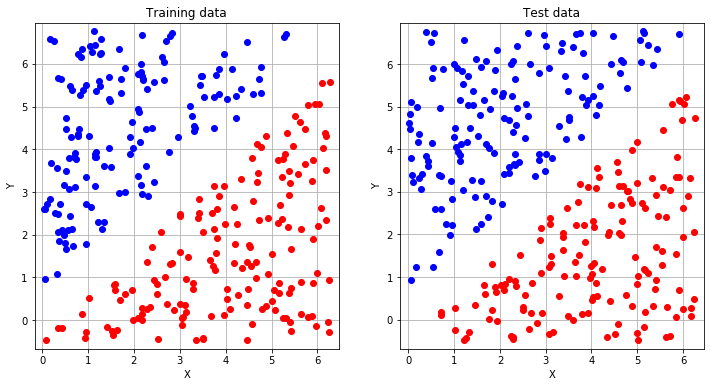

In [5]:
# Problem data:
n = 300
model = 'linear'
ymargin = 0.5
x, y, clase = createDataSet(n, model, ymargin)
xtest, ytest, clasetest = createDataSet(n, model, ymargin)

# Plots:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotData(x,y,clase,'ro','bo',"Training data")
plt.subplot(122)
plotData(xtest,ytest,clasetest,'ro','bo',"Test data")

A continuación vamos a entrenar un clasificador <a href="http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html">SVC</a> para separar las dos clases. Los argumentos más importantes que utiliza el constructor de SVC son el tipo de kernel, el grado y el coeficiente de orden 0 (para kernels polinómicos), el parámetro gamma que determina la anchura del kernel (para kernels gausianos), y el parámetro de complejidad *C* (valores más altos implican modelos con menos error pero más complejos, es decir con menos margen). El constructor admite argumentos adicionales que puedes consultar en la <a href="http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html">documentación</a>.

Como el problema es linealmente separable, será suficiente con un kernel lineal. Para construir el clasificador (método *fit*) utilizamos los datos de entrenamiento.

In [6]:
clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1)
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

SVC(C=10.0, cache_size=200, class_weight=None, coef0=1.0,
    decision_function_shape='ovr', degree=1.0, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Ahora obtenemos el acierto, tanto en entrenamiento como en test, utilizando el método *score*. Puedes ver que para este problema se clasifican bien todos los patrones (score = 1).

In [7]:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

Score train = 1.000000
Score test = 1.000000


Y finalmente dibujamos el modelo sobre los datos de entrenamiento y test. La línea negra es la frontera de separación, mientras que las líneas azul y roja representan los márgenes para las clases azul y roja respectivamente.

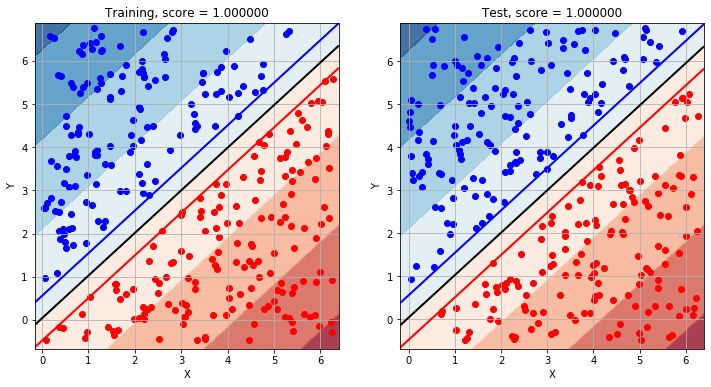

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(122)
plotModel(xtest,ytest,clasetest,clf,"Test, score = %f" % (score_test))

En la siguiente celda hemos colocado todo el código anterior para que te resulte más cómodo hacer pruebas. Realiza las modificaciones que necesites y responde razonadamente a las cuestiones planteadas al final.

Score train = 0.983333
Score test = 0.753333


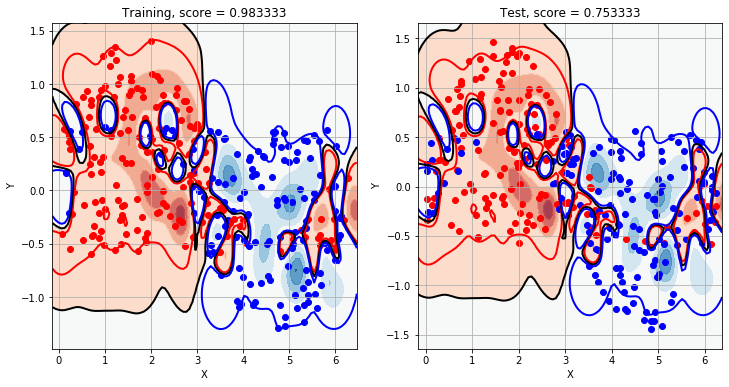

In [14]:
# Creación del problema, datos de entrenamiento y test:
n = 300
model = 'sine'
ymargin = -0.5
x, y, clase = createDataSet(n, model, ymargin)
xtest, ytest, clasetest = createDataSet(n, model, ymargin)

# Construcción del clasificador:
clf = SVC(C=1000, kernel='rbf', degree=1.0, coef0=1.0, gamma=10.0)
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

# Gráficas:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(122)
plotModel(xtest,ytest,clasetest,clf,"Test, score = %f" % (score_test))

**(1)** Con el conjuto de datos anterior, prueba a entrenar el clasificador con un parámetro C igual a 0.01. ¿Se siguen clasificando bien todos los patrones? ¿Qué ocurre con el margen? ¿Qué pasa si bajas aún más el valor de C hasta 0.001? Razona tus respuestas.

**(2)** Genera un nuevo conjunto de datos manteniendo el modelo lineal pero cambiando el parámetro *ymargin* a -0.5. Como ves ahora el problema ya no es linealmente separable. Prueba a resolverlo con el clasificador inicial (con *C=10*) y también usando kernels más complejos (prueba con uno polinómico de grado 4 y con uno RBF, y con distintos valores de *C*). Presenta tus resultados para los distintos clasificadores (score en entrenamiento y test) en una tabla. ¿Qué clasificador es mejor sobre el conjunto de entrenamiento? ¿Y sobre el conjunto de test? Si tuvieras que elegir un modelo para este problema, ¿con cuál te quedarías? ¿Por qué?

**(3)** Repite el apartado (2) usando un nuevo conjunto de datos con modelo 'square' e *ymargin = -5*. Encuentra kernel y el conjunto de parámetros que mejor resultado proporcionan, y justifica tu respuesta.

**(4)** Repite el apartado (2) usando un nuevo conjunto de datos con modelo 'sine' e *ymargin = -0.2*. Encuentra el kernel y el conjunto de parámetros que mejor resultado proporcionan, y justifica tu respuesta.

### 2. Interpretando el modelo:

En muchos casos es interesante entender el modelo que hemos ajustado a los datos, no solo clasificarlos. Para acceder a esta información en el caso de *SVC* utilizamos los atributos siguientes del clasificador recién entrenado:

- *`support_`*, es un array con los índices de todos los vectores de soporte

- *`support_vectors_`*, es un array con todos los vectores de soporte, tiene tantas filas como número de vectores de soporte y tantas columnas como la dimensión del espacio de atributos (el original, no el transformado)

- *`dual_coef_`*, es un array con los coeficientes $a_{i}$ asociados a cada uno de los vectores de soporte. El coeficiente $a_{i}$ es el producto de la clase del punto y su multiplicador de Lagrange correspondiente: $a_{i} = \alpha_{i} t_{i}$. Por este motivo encontramos valores negativos.

- *`intercept_`*, es la constante $b$ que aparece en la ecuación de la frontera de decisión

Por ejemplo, en la siguiente celda se entrena un clasificador y se accede a los vectores de soporte para imprimirlos y dibujarlos junto a la frontera de decisión. También se imprimen los valores de los coeficientes $a_{i}$ y $b$. Con la información que genera este código, responde a las cuestiones del final.

Vectores de soporte:
[2.319006, 1.685278]  c = 0
[4.913743, 3.905690]  c = 0
[3.952677, 2.603395]  c = 0
[4.096140, 3.426486]  c = 0
[5.394687, 1.920488]  c = 0
[3.686990, 2.703049]  c = 0
[3.053010, 1.041796]  c = 0
[1.145998, 0.328377]  c = 0
[4.379683, 2.793567]  c = 0
[2.684788, 1.519713]  c = 0
[4.075978, 0.256042]  c = 0
[3.247598, -0.090896]  c = 0
[4.665185, 1.236592]  c = 0
[1.941806, 0.006321]  c = 0
[6.139756, 3.570509]  c = 0
[2.286230, 0.730583]  c = 0
[3.169259, 0.408320]  c = 0
[5.084144, 2.548228]  c = 0
[2.741230, 1.292384]  c = 0
[5.226425, 4.305914]  c = 0
[4.036729, -0.033288]  c = 0
[4.503462, 2.272948]  c = 0
[2.834487, 4.944142]  c = 1
[1.388724, 5.365470]  c = 1
[1.826998, 4.713756]  c = 1
[5.096256, 6.235428]  c = 1
[2.518241, 6.092927]  c = 1
[0.163358, 6.471615]  c = 1
[3.828804, 5.373033]  c = 1
[4.424420, 5.856622]  c = 1
[4.300315, 6.514617]  c = 1
[0.706030, 5.963064]  c = 1
[2.314429, 5.073960]  c = 1
[2.512130, 5.906047]  c = 1
[2.597145, 3.933642]  c =

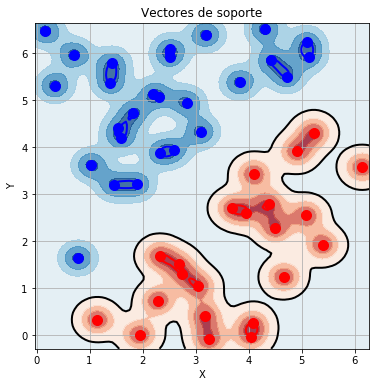

In [10]:
# Creación del problema:
np.random.seed(300)
n = 50
model = 'linear'
ymargin = 0.5
x, y, clase = createDataSet(n, model, ymargin)

# Construcción del clasificador:
clf = SVC(C=1, kernel='rbf', degree=2.0, coef0=1.0, gamma=10.1)
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Vectores de soporte:
print("Vectores de soporte:")
for i in clf.support_:
    print("[%f, %f]  c = %d" % (x[i], y[i], clase[i]))

# Coeficientes a_i y b:
print("Coeficientes a_i:")
print(clf.dual_coef_)
print("Coeficiente b:")
print(clf.intercept_)

# Gráficas:
plt.figure(figsize=(6,6))
plotModel(x,y,clase,clf,"Vectores de soporte")
for i in clf.support_:
    if clase[i] == 0:
        plt.plot(x[i],y[i],'ro',ms=10)
    else:
        plt.plot(x[i],y[i],'bo',ms=10)

**(1)** Escribe la ecuación de la frontera de decisión para este problema como combinación lineal de las funciones de kernel sobre cada uno de los vectores de soporte. 

**(2)** Genera un nuevo conjunto de datos manteniendo el modelo lineal pero cambiando el parámetro ymargin a -0.5. ¿Qué ocurre con el problema? ¿Y con la frontera aprendida? ¿Qué ocurre con los vectores de soporte? ¿Qué tipos de vectores de soporte observas? Sobre la gráfica generada, intenta etiquetar cada vector de soporte con los valores de $\alpha$, $\xi$ y $\mu$ (vale una aproximación) para el mismo.

**(3)** Sobre el problema anterior, prueba a cambiar el parámetro *C*. ¿Qué ocurre con valores altos de *C*? ¿Y con valores bajos? ¿Qué ocurre con los vectores de soporte?

**(4)** Repite las pruebas anteriores con nuevos conjuntos de datos con frontera de separación no lineal y explica lo que observas.


### 3. Búsqueda automática de parámetros mediante validación cruzada:

En alguna de las cuestiones anteriores se te pedía buscar el tipo de modelo y los parámetros que mejor funcionaban para alguno de los problemas. La forma más correcta de hacer esto es mediante validación cruzada. Para realizar esta tarea *sklearn* proporciona la clase <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">GridSearchCV</a>, dentro del paquete *sklearn.model_selection*. A continuación se proporciona código que realiza la búsqueda automática de parámetros (incluyendo el tipo de kernel) para un problema de tipo *sine* con *y_margin = -0.2*. 

Observa que lo que hacemos es crear un <a href="https://docs.python.org/2/tutorial/datastructures.html#dictionaries">diccionario</a> (variable *grid*) en el que las claves son los nombres de cada uno de los parámetros con los que queremos jugar (C, gamma, kernel, degree y coef0) y los valores son listas con los valores de cada parámetro que queremos probar. Por ejemplo, para el parámetro *C* se probarán los valores 1, y 10. 

A continuación, al constructor de la clase *GridSearchCV* le pasamos el tipo de clasificador que vamos a utilizar (estimator=SVC()), el diccionario con los parámetros a probar (param_grid=grid) y el número de folds a usar en la validación cruzada (cv=5).

Finalmente se imprimen los resultados y se dibuja el modelo para el clasificador que mejor funciona.

Best score = 0.866859
Best model:
SVC(C=1, cache_size=200, class_weight=None, coef0=1.0,
    decision_function_shape='ovr', degree=2.0, gamma=10.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Score in training set = 0.930000
Score in test set = 0.853333


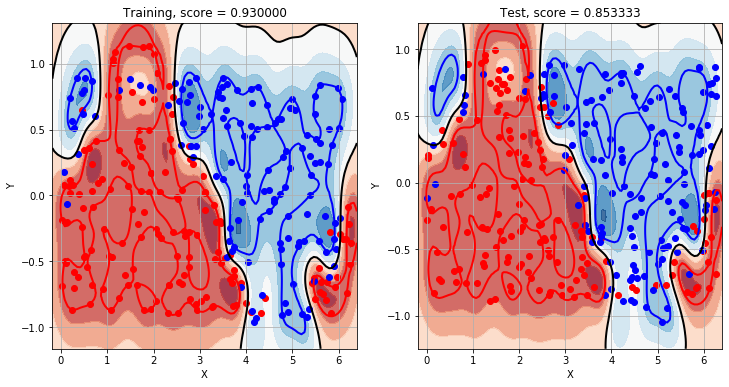

In [11]:
from sklearn.model_selection import GridSearchCV

# Creación del problema:
np.random.seed(199)
n = 300
model = 'sine'
ymargin = -0.2
x, y, clase = createDataSet(n, model, ymargin)
xtest, ytest, clasetest = createDataSet(n, model, ymargin)

# Construcción de los clasificadores, validación cruzada:
grid = {'C': [1, 10],
         'gamma': [10.0, 1.0], 
         'kernel': ['poly', 'rbf'], 
         'degree': [2.0], 
         'coef0': [1.0]}
clf_gridsearch = GridSearchCV(estimator=SVC(), param_grid=grid, cv=5, iid=False)
clf_gridsearch.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Imprimimos los resultados para el mejor clasificador:
print("Best score = %f" % (clf_gridsearch.best_score_))
clf = clf_gridsearch.best_estimator_
print("Best model:")
print(clf)

# Calculamos el acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score in training set = %f" % (score_train))

score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score in test set = %f" % (score_test))

# Gráficas:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(122)
plotModel(xtest,ytest,clasetest,clf,"Test, score = %f" % (score_test))

**(1)** Cambia la variable *grid* para realizar una búsqueda de parámetros lo más completa posible. ¿Qué parámetros son los óptimos para el SVM según esta búsqueda automática? **Nota:** Si utilizas un grid muy grande, es posible que tu programa tarde mucho en ejecutar.

**(2)** ¿Por qué no son iguales *Best score* y *Score in training set*?

**(3)** ¿Se parecen *Best score* y *Score in test set*? ¿Es esto lo que debemos esperar?